In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt 
import h5py
from glob import glob
import json
import sys
from tqdm import tqdm
sys.path.append("../models/")
from forward_model import model
from posterior_sampling import complex_to_real


ModuleNotFoundError: No module named 'h5py'

In [ ]:
def model(t, x, score_model, model_parameters): 
    """Apply a physical model A to a ground-truth x.

    Args:
        t (torch.Tensor): temperature in the sampling procedure of diffusion models.
        x (torch.Tensor): ground-truth 
        score_model (torch.Tensor): trained score-based model (= the score of a prior)
        model_parameters (Tuple): list of parameters for the model (sampling_function, B, C)
          - index 0: sampling function (mask selecting the measured visibilities in Fourier space, must have a shape (H, W) where H and W are the height
            and width of the padded image respectively)
          - index 1 and index 2: B and C, the link_function parameters (see function link_function)

    Returns:
        y_hat (torch.Tensor): 
    """

    sampling_function, B, C, pad= model_parameters
    x = link_function(x, B, C)    
    x_padded = noise_padding(x, pad = pad, sigma = sigma(t, score_model))
    vis_sampled = ft(x_padded).squeeze()[sampling_function] # some troublesome bug makes the squeeze needed here
    print(vis_sampled.shape)
    y_hat = complex_to_real(vis_sampled)
    return y_hat


### Recall $\chi^2$ distribution

Let's say we have $\nu$ normally distributed random variables. The $\chi^2$ is defined as 

$$
\chi^2_0 = \sum_{i=0}^k z_i^2
$$
where $z_i\sim \mathcal{N}(0, \mathbb{1})$

In [4]:
from score_models import ScoreModel

ModuleNotFoundError: No module named 'score_models'

In [3]:
score_model = ScoreModel(checkpoints_directory = "../../score_models/ncsnpp_vp_skirt_y_64_230813225149")

NameError: name 'ScoreModel' is not defined

In [4]:
def open_h5(file):
    return h5py.File(file, "r")

def open_json(file):
    with open(file, "r") as f:
        data = json.load(f)  
        f.close()
    return data

In [5]:
data_dir = "../../../data/tarp_data/pc/"
params_dir = data_dir + "skirt64_postneurips_pc.json" 

# Loading experiment params
params = open_json(params_dir)
num_sims = params["num_sims"]
num_samples = params["num_samples"]
model_pixels = params["model_pixels"]
dataset = params["dataset"]
sde = params["sde"]
experiment_name = params["experiment_name"]
pc_params = params["sampling_params"] # (Predictor, Corrector, SNR)
sigma_y = params["sigma_y"]

In [54]:
experiment_name

'skirt64_postneurips_pc'

In [6]:
paths = glob(data_dir + experiment_name + "*.h5")

In [16]:
hf = open_h5(paths[0])
hf["model"]

<HDF5 dataset "model": shape (500, 1, 64, 64), type "<f4">

In [9]:
hf.keys()

<KeysViewHDF5 ['ground_truth', 'model', 'observation', 'reconstruction']>

In [13]:
hf.keys()

<KeysViewHDF5 ['ground_truth', 'model', 'observation', 'reconstruction']>

In [8]:
hf["reconstruction"]

<HDF5 dataset "reconstruction": shape (500, 7412), type "<f4">

In [8]:
# Loading posterior samples and computing chi^2 
paths = glob(data_dir + experiment_name + "*.h5")
chi_squared = np.empty(shape = (num_sims, num_samples))
sampling_function = torch.tensor(np.load( "../../../data/data_htlup/sampling_function3.npy"))[:256**2].reshape(256, 256)


y_hat = np.empty(shape = (num_samples, 7412))
chi_squared2 = np.empty(shape = (num_sims, num_samples))
idx_to_del = []
for i, path in tqdm(enumerate(paths)):
    try: 
        hf = open_h5(path)
        y = np.array(hf["observation"])
        samples = torch.tensor(hf["model"])
        for j in range(num_samples):
            y_hat[j] = model(torch.zeros(1), samples[j], score_model = score_model, model_parameters = (sampling_function, 1, 0, 96)).cpu().squeeze().numpy().astype(np.float32)
        #y_hat = np.array(hf["reconstruction"])
        np.save(data_dir + experiment_name + f"_{i+1}.npy",y_hat)
        chi_squared2[i] = np.sum((y - y_hat) ** 2 / sigma_y ** 2, axis = 1)
    except OSError: 
        idx_to_del.append(i)
    hf.close()

0it [00:00, ?it/s]

500it [08:25,  1.01s/it]


In [42]:
sampling_function = torch.tensor(np.load( "../../../data/data_htlup/sampling_function3.npy"))[:256**2].reshape(256, 256)
for i, path in tqdm(enumerate(paths)):
    
    with h5py.File(path, "r+") as hf:
        samples = torch.tensor(hf["model"])
        for j in range(num_samples):
            y_hat[j] = model(torch.zeros(1), samples[j], score_model = score_model, model_parameters = (sampling_function, 1, 0, 96)).cpu().squeeze().numpy().astype(np.float32)
    hf.close()
    

0it [00:00, ?it/s]


OSError: Unable to open file (file is already open for read-only)

In [10]:
chi_squared = np.empty(shape = (num_sims, num_samples))
idx_to_del = []

for i, path in (pbar:= tqdm(enumerate(paths))):
    pbar.set_description(f"Computing the chi squared for the simulation {i}/{num_sims}")
    try:
        hf = open_h5(path)
        y = np.array(hf["observation"])
        y_hat = np.load(data_dir + experiment_name + f"_{i+1}.npy")
        chi_squared[i] = np.sum((y - y_hat) ** 2 / sigma_y ** 2, axis = 1)

    except OSError:    
        print("Detected a corrupted file")
        idx_to_del.append(i)
    hf.close()


Computing the chi squared for the simulation 394/500: : 395it [00:36, 11.61it/s]

Detected a corrupted file


Computing the chi squared for the simulation 468/500: : 469it [00:44, 11.75it/s]

Detected a corrupted file


Computing the chi squared for the simulation 499/500: : 500it [00:47, 10.43it/s]


In [11]:
chi_squared2.flatten()

array([7368.33857815, 7378.3019664 , 7375.57602224, ..., 7457.93400676,
       7489.07423984, 7480.36734417])

In [13]:
chi_squared.flatten() - chi_squared2.flatten()

array([0., 0., 0., ..., 0., 0., 0.])

In [51]:
chi_squared2[466]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [52]:
chi_squared[466]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [26]:
idx,=np.where(chi_squared.flatten() - chi_squared2.flatten()>1e-4)

In [27]:
len(idx)

152897

In [24]:

for i in range(num_samples):
    chi[i] = np.sum((y[i] - y_hat[i])**2 / sigma_y ** 2, axis = -1)

In [27]:
y_hat.shape

(500, 7412)

In [14]:
y_hat

<HDF5 dataset "reconstruction": shape (500, 7412), type "<f4">

In [13]:
chi_squared

In [52]:
chi_squared

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
chi_square = np.delete(chi_squared2.flatten(), np.where(chi_squared2.flatten()<4000)[0])

In [1]:
from scipy.stats import chi2
from scipy.optimize import minimize
def chi2_pdf(x, k): 
    return chi2.pdf(x, k)

def neg_log_likelihood(k, x): 
    print(k.shape)
    return - np.sum(np.log(chi2_pdf(x, k)))

In [ ]:
chi2.fit()

In [16]:
result = minimize(neg_log_likelihood, x0 = 7412 , args=(chi_squared.flatten(),))
optimal_k = result.x[0]

C:\Users\noedi\AppData\Local\Temp\ipykernel_22736\2864458750.py:7: RuntimeWarning: divide by zero encountered in log
  return - np.sum(np.log(chi2_pdf(data, params[0])))
c:\Users\noedi\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [18]:
x = np.linspace(chi_squared.min()-500, chi_squared.max()+500, 1000)
f = chi2_pdf(x, optimal_k)

(6497.193824739817, 10651.306468553581)

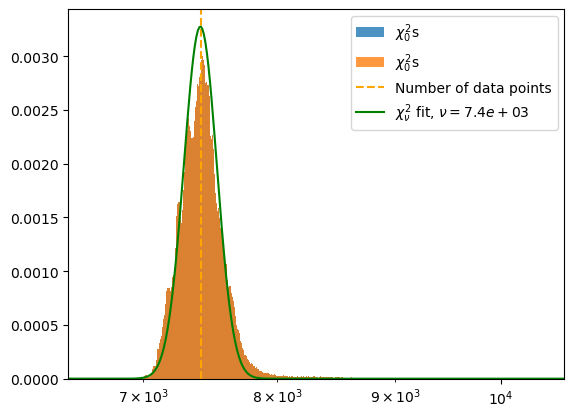

In [20]:
plt.hist(chi_square, bins = 400, alpha = 0.8, density = True, label = r"$\chi^2_0$s")
plt.hist(np.delete(chi_squared, np.where(chi_squared.flatten()<4000)[0]).flatten(), bins = 400, alpha = 0.8, density = True, label = r"$\chi^2_0$s")
plt.axvline(len(y), label = "Number of data points", color = "orange", linestyle = "dashed")
plt.xscale("log")
plt.plot(x, f, color = "green", label = rf"$\chi_\nu^2$ fit, $\nu={optimal_k:.2g}$")
plt.legend()
plt.xlim([chi_square.min()-500, chi_square.max()+500])

In [49]:
obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
obs

array([[16, 32],
       [18, 24],
       [16, 16],
       [14, 28],
       [12, 20],
       [12, 24]])

In [9]:
y_hat.numpy()

array([ 0.42969602, -0.42732123,  0.4203627 , ..., -0.01191171,
        0.0092379 , -0.0066658 ], dtype=float32)

In [20]:
type(samples[i])

numpy.ndarray

In [5]:
# Loading posterior samples and computing chi^2
chi_squared = np.empty(shape = (num_sims, num_samples))

for i in range(num_sims): 

In [7]:
params.keys()

dict_keys(['num_samples', 'num_sims', 'model_pixels', 'dataset', 'sde', 'experiment_name', 'sampling_params'])

In [9]:
h5 = open_h5(paths[0])

In [10]:
chi_squared = np.empty(shape = (num_sims, num_samples))

In [59]:
import torch
x = torch.randn(size = (10, 1, 64, 64))

In [67]:
def noise_padding(x, pad, sigma):
    """Padding with realizations of noise of the same temperature of the current diffusion step

    Args:
        x (torch.Tensor): ground-truth 
        pad (int): amount of pixels needed to pad x
        sigma (torch.Tensor): std of the gaussian distribution for the noise pad around the model

    Returns:
        out (torch.Tensor): noise padded version of the input
    """

    # To manage batched input
    if len(x.shape)<4:
        _, H, W = x.shape
    else: 
        _, _, H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad)) 
    # Create a mask for padding region
    mask = torch.ones_like(out)
    mask[pad:pad + H, pad:pad+W] = 0.
    
    # Noise pad around the model
    z = torch.randn_like(out) * sigma
    out = out + z * mask
    return out

In [68]:
noise_padding(x, pad = 96, sigma = sigma_y).shape

torch.Size([10, 1, 256, 256])

In [5]:
h5.keys()

<KeysViewHDF5 ['ground_truth', 'model', 'observation', 'reconstruction']>

In [22]:
sigma_y = 1e-2

In [ ]:
chi_squared = np.empty(shape = (500, ))

In [15]:
y_hat = np.array(h5["reconstruction"])

In [39]:
y = np.array(h5["observation"])

In [57]:
y_hat[0]

array([ 0.4319004 , -0.42957777,  0.4227407 , ..., -0.01244728,
        0.00954933, -0.00679338], dtype=float32)

In [20]:
fig, axs = plt.subplots(5, 5, figsize = (4*5, 4*5))

for i in range(5):
    for j in range(5):
        axs[i,j].imshow()

(7412,)

In [55]:
chi_squared = (((y_hat-y)** 2).sum(axis=1)/ sigma_y ** 2)

In [56]:
chi_squared.shape

(500,)

In [52]:
x = np.array([[2,1, 1],[2,2, 1]] )
x.shape

(2, 3)

In [54]:
(x.sum(axis = 1)).shape

(2,)

In [28]:
chi_squared[0]

7396.734

In [30]:
chi_squared[1]

7396.734